In [1]:
!pip install google-api-python-client
!python -c "from oauth2client import crypt"
!pip install pyCrypto

     |████████████████████████████████| 446 kB 2.6 MB/s 
  Created wheel for pyCrypto: filename=pycrypto-2.6.1-cp37-cp37m-linux_x86_64.whl size=499932 sha256=ebc04da3d166a29fe807908addcafe9327945b8becb661fea7ed99e7e49f8437
  Stored in directory: /root/.cache/pip/wheels/cf/85/ba/bbd7c96add459de7598fb424e5ff2309baf2095c844ac0f191
Successfully built pyCrypto


#Connecting GEE with other Google Services

In [2]:
!pip install earthengine-api
!pip install geojson
!pip install geopandas

     |████████████████████████████████| 994 kB 2.6 MB/s 
     |████████████████████████████████| 6.3 MB 41.0 MB/s 
     |████████████████████████████████| 15.4 MB 35 kB/s 


#**Authentication**

To read/write from a Google Drive or Google Cloud Storage bucket to which you have access, it's necessary to authenticate (as yourself). You'll also need to authenticate as yourself with Earth Engine, so that you'll have access to your scripts, assets, etc.

Authenticate to Earth Engine
In order to access Earth Engine, signup at signup.earthengine.google.com.

In [3]:
!earthengine authenticate

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=lI8Lxwoy5IaIiWeE0fi7emVIeEtnxGnTSmw8NJEuQiI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWirZ1nDyo_GStK1OpuMBEoZqi8qUPPkrxYql77qghQQ8GeXDK4QT6Q

Successfully saved authorization token.


#**Authenticate Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Authenticate to Google Cloud**

In [5]:
from google.colab import auth
auth.authenticate_user()

# **Import earth engine API and initialize it**

As you can see in the description of the datasets, they include several sets of information stored in several bands. For example, these bands are associated with the LST collection:

LST_Day_1km: Daytime Land Surface Temperature

Day_view_time: Local time of day observation

LST_Night_1km: Nighttime Land Surface Temperature
etc.

In [9]:
import ee
ee.Initialize()
import folium
import webbrowser

%matplotlib inline
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import geojson
import requests
import geopandas as gpd
import numpy as np

# import rasterio as rio
# from rasterio.plot import show
# import rasterio.mask

# from rasterio import windows
# from shapely.geometry import box
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline
from datetime import date
# import ee
# import geemap
# import geemap.eefolium as emap
# import folium

In [10]:
area_geometry= ee.Geometry.Point(5.2913,52.1326)

In [12]:
netharland_collection= ee.ImageCollection("MODIS/006/MOD11A1")

In [14]:
# Initial date of interest (inclusive).
i_date = '2000-01-01'

# Final date of interest (exclusive).
f_date = str(date.today())

# Selection of appropriate bands and dates for LST.
netharland_collection_lst = netharland_collection.select('LST_Day_1km','LST_Night_1km').filterDate(i_date, f_date)

# **Get a time series**

Now that you see we can get geospatial information about a place of interest pretty easily, you may want to inspect a time series, probably make some charts and calculate statistics about a place. Hence, we import the data at the given locations using the getRegion() method.

In [16]:
scale= 100

# Get the data for the pixel intersecting the point in urban area.
lst_point = netharland_collection_lst.getRegion(area_geometry, scale).getInfo()

# Preview the result.
lst_point[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'LST_Night_1km'],
 ['2000_02_24',
  5.2915261811060414,
  52.13238004095025,
  951350400000,
  None,
  None],
 ['2000_02_25',
  5.2915261811060414,
  52.13238004095025,
  951436800000,
  14055,
  13676],
 ['2000_02_26',
  5.2915261811060414,
  52.13238004095025,
  951523200000,
  14168,
  13606],
 ['2000_02_27',
  5.2915261811060414,
  52.13238004095025,
  951609600000,
  None,
  None]]

In [17]:
def ee_array_to_df(arr,list_of_bands):
  """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
  df= pd.DataFrame(arr)

  #Reaarange the header
  headers= df.iloc[0]
  df= pd.DataFrame(df.values[1:],columns=headers)

  #Remove row withoout data inside
  df= df[['longitude','latitude','time',*list_of_bands]].dropna()

  # Convert the data to numeric values
  for band in list_of_bands:
    df[band]= pd.to_numeric(df[band],errors='coerce')

  # Convert the time field into a datetime.
  df['datetime']=pd.to_datetime(df['time'],unit='ms')

  #keep column of interest
  df= df[['time','datetime',*list_of_bands]]


  return df

In [18]:
lst_df = ee_array_to_df(lst_point,['LST_Day_1km','LST_Night_1km'])

In [19]:
def t_modis_to_celsius(t_modis):
  """Converts MODIS LST units to degrees Celsius."""
  t_celsius =  0.02*t_modis - 273.15
  return t_celsius

# Apply the function to get temperature in celsius.
lst_df['LST_Day_1km'] = lst_df['LST_Day_1km'].apply(t_modis_to_celsius)
lst_df['LST_Night_1km'] = lst_df['LST_Night_1km'].apply(t_modis_to_celsius)

In [20]:
lst_df.head(5)

,time,datetime,LST_Day_1km,LST_Night_1km
1,951436800000,2000-02-25,7.95,0.37
2,951523200000,2000-02-26,10.21,-1.03
27,953683200000,2000-03-22,18.95,2.21
43,955065600000,2000-04-07,15.85,0.35
45,955238400000,2000-04-09,20.45,2.83


In [22]:
lst_df.shape

(1111, 4)

In [21]:
lst_df.to_csv('Netherland_LST_data_2000_to_2021.csv',index=False)

# **Visualization of Time Series Data**

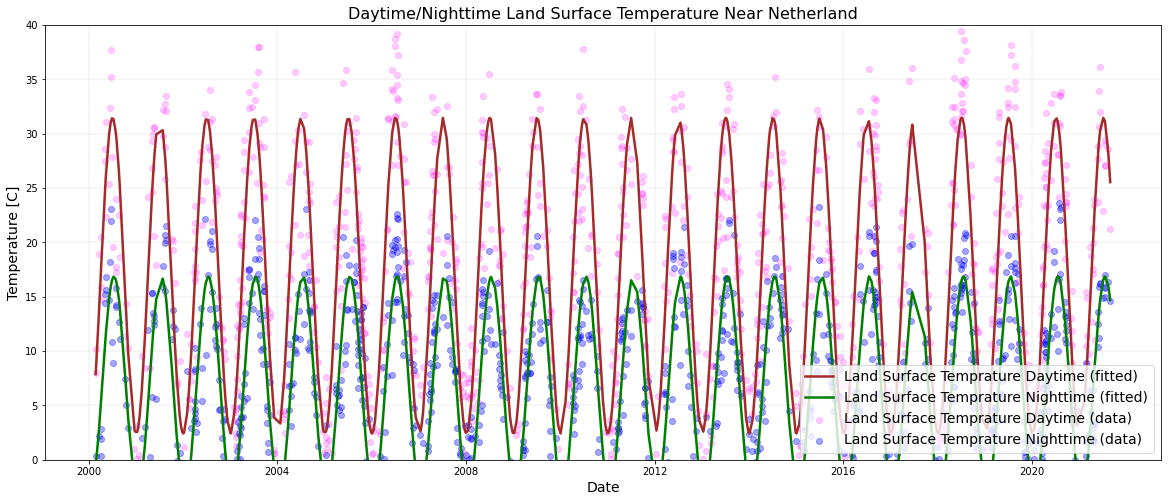

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data = np.asanyarray(lst_df['time'].apply(float))  

## Secondly, extract y values (LST) from the dfs.
y_data_day = np.asanyarray(lst_df['LST_Day_1km'].apply(float)) 
y_data_night = np.asanyarray(lst_df['LST_Night_1km'].apply(float)) 

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_d, params_covariance_d = optimize.curve_fit(fit_func, x_data, y_data_day, p0=[lst0, delta_lst, tau, phi])
params_n, params_covariance_n = optimize.curve_fit(fit_func, x_data, y_data_night, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(20,8))

# Add scatter plots.
ax.scatter(lst_df['datetime'], lst_df['LST_Day_1km'],c='magenta', alpha=0.2, label='Land Surface Temprature Daytime (data)')
ax.scatter(lst_df['datetime'], lst_df['LST_Night_1km'],c='blue', alpha=0.35, label='Land Surface Temprature Nighttime (data)')

# Add fitting curves.
ax.plot(lst_df['datetime'],fit_func(x_data, params_d[0], params_d[1], params_d[2], params_d[3]),label='Land Surface Temprature Daytime (fitted)', color='brown', lw=2.5)
ax.plot(lst_df['datetime'],fit_func(x_data, params_n[0], params_n[1], params_n[2], params_n[3]),label='Land Surface Temprature Nighttime (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime/Nighttime Land Surface Temperature Near Netherland', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()